In [ ]:
import numpy as np
import pandas as pd


class Node:
    def __init__(self):
        # links to the left and right child nodes
        self.right = None
        self.left = None

        # split criterion, recording the best split obtained
        # also used in the prediction part to identify the suitable class
        self.column = None
        self.threshold = None

        # probability for object inside the Node to belong for each of the given classes
        self.probas = None
        # depth of the given node
        self.depth = None

        # if it is the root Node or not
        self.is_terminal = False


class DecisionTreeClassifierImpl:
    def __init__(self, max_depth=3, min_samples_leaf=1, min_samples_split=2, criterion="gini"):
        """
        :param max_depth:
        The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
        :param min_samples_leaf:
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.
        This may have the effect of smoothing the model, especially in regression.
        :param min_samples_split:
        The minimum number of samples required to split an internal node:

        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        # Used to store unique class passed from target y
        self.classes = None

        # Decision tree itself
        self.Tree = None

        # Define the criterion
        self.criterion = criterion

    def node_probas(self, y):
        """
        Calculates probability of one single class in a given node
        :param y: given node y, one single class of label
        :return: the probability of different class in a single node (np.array)
        """
        probas = []

        for one_class in self.classes:
            num_rows = y.shape[0]
            num_match_class = y[one_class == y].shape[0]
            proba = num_match_class / num_rows
            probas.append(proba)

        return np.asarray(probas)

    def gini(self, probas):
        """
        gini impurity computes the degree of probability of a specific variable
        https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

        :param probas: calculated from the previous node_probas function (np.array)
        :return: gini impurity value
        """

        return 1 - np.sum(probas ** 2)

    def cross_entropy(self, probas):
        """
        Calculates the mutual information gain criterion (entropy)
        :return: cross entropy value
        """
        # epsilon is required for
        epsilon = 0.000001
        return -np.sum(probas * np.log2(probas + epsilon))

    def calculate_impurity(self, y):
        """
        Wrapper for the impurity calculation. Calculates probas first and then passses them
        to the gini criterion

        :param y: numpy array obtained from the previous node_probas() method
        :return: gini criterion
        """

        if self.criterion == "gini":
            return self.gini(self.node_probas(y))

        if self.criterion == "entropy":
            return self.cross_entropy(self.node_probas(y))

        pass

    def find_best_split(self, X, y):
        """
        Calculate the best split based on the input X data and target y label
        :param X: (numpy format)
        :param y: (numpy format) with target label
        :return: best_split_col, best_threshold, x_left, y_left, x_right, y_right
        """

        # obtain the impurity before the split
        impurity_before_split = self.calculate_impurity(y)

        # initialize three variables to record the best parameter in the following for loop
        best_threshold = None
        best_split_col = None
        best_info_gain = float('-inf')

        num_col = X.shape[1]

        # iterate through the columns
        for col in range(num_col):
            # for each single column, calculate the impurity
            x_col = X[:, col]
            # iterate through all the value in this columns and make comparison
            for i in x_col:
                # each row value as the threshold to calculate the impurity
                inner_threshold = i

                # identify the left child node
                y_left = y[x_col <= inner_threshold]

                # identify the right child node
                y_right = y[x_col > inner_threshold]

                # make some clean check to ensure the extreme case, where subtree has zero child.
                if len(y_right) == 0 or len(y_left) == 0:
                    continue

                # impurity after the split
                impurity_left = self.calculate_impurity(y_left)
                impurity_right = self.calculate_impurity(y_right)

                impurity_after_split = impurity_left * (len(y_left) / len(y)) + impurity_right * (len(y_right) / len(y))

                # obtain the information gain
                info_gain = impurity_before_split - impurity_after_split

                # check whether higher than the best information gain
                if info_gain > best_info_gain:
                    best_split_col = col
                    best_info_gain = info_gain
                    best_threshold = inner_threshold

        if best_info_gain == float('-inf'):
            return None, None, None, None, None, None

        # identify the best split and the regarding x, y data in each branch
        X_col = X[:, best_split_col]
        X_left, X_right = X[X_col <= best_threshold, :], X[X_col > best_threshold, :]
        y_left, y_right = y[X_col <= best_threshold], y[X_col > best_threshold]

        return best_split_col, best_threshold, X_left, X_right, y_left, y_right

    def build_DTree(self, X, y, node):
        """
        Recursively builds decision tree from the top to bottom

        :param X: numpy array
        :param y: numpy array
        :param node: the current node, used to monitor condition, with depth recorded
        :return:
        """

        # Check the terminal condition
        check_before_split = node.depth >= self.max_depth or len(X) < self.min_samples_split or len(np.unique(y)) == 0

        if check_before_split:
            node.is_terminal = True
            return

        best_split_col, best_threshold, X_left, X_right, y_left, y_right = self.find_best_split(X, y)

        check_after_split = best_split_col == None or len(X_left) < self.min_samples_leaf or len(
            X_right) < self.min_samples_leaf

        if check_after_split:
            node.is_terminal = True
            return

        # record the information of best split
        node.column = best_split_col
        node.threshold = best_threshold

        # initialize the left and right node
        left_node, right_node = Node(), Node()
        left_node.depth, right_node.depth = node.depth + 1, node.depth + 1
        left_node.probas, right_node.probas = self.node_probas(y_left), self.node_probas(y_right)

        node.left = left_node
        node.right = right_node

        self.build_DTree(X_left, y_left, left_node)
        self.build_DTree(X_right, y_right, right_node)

    def fit(self, X, y):
        """
        Standard fit function to run all the model training

        :param X: pd.DataFrame or numpy array, if pd, need to convert to acceptable size
        :param y: the target label, numpy format
        :return: noting
        """
        if type(X) == pd.DataFrame:
            X = np.asarray(X)

        self.classes = np.unique(y)

        # Initialize the root node object, depth, the impurity value at first node
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.probas = self.calculate_impurity(y)

        # init and conduct the whole decision tree training by calling build_DTree
        self.build_DTree(X, y, self.Tree)

    def predict_sample(self, X, node):
        """
        iteratively predict the sample label's probability based on the best split columns and best threshold
        obtained from the previous training.
        :param X: the input data for prediction
        :param node:
        :return:
        """

        if node.is_terminal:
            return node.probas

        if X[node.column] > node.threshold:
            probas = self.predict_sample(X, node.right)
        else:
            probas = self.predict_sample(X, node.left)

        return probas

    def predict(self, X):
        """
        predict api for the class given testing data
        :param X:
        :return:
        """
        if type(X) == pd.DataFrame:
            X = np.asarray(X)

        predictions = []

        for i in X:
            pred_label = np.argmax(self.predict_sample(i, self.Tree))
            predictions.append(pred_label)

        return np.asarray(predictions)


In [1]:
import pandas as pd
import numpy as np 
BRCA = pd.read_csv("/content/drive/MyDrive/ml_project/data/BRCA.txt", delimiter="\t")
columns = BRCA.columns
# y labels
Y = [1 if i[-3:] == '11A' else 0 for i in columns]
BRCA = BRCA.T
BRCA['Y'] = Y

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

In [7]:
df = BRCA
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25, shuffle=True)
y_train = training_data['Y']
y_test = testing_data['Y']
X_train = StandardScaler().fit_transform(training_data.drop("Y", axis=1))
X_test = StandardScaler().fit_transform(testing_data.drop("Y", axis=1))

clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2, criterion="entropy")
# clf = DecisionTreeClassifierImpl(max_depth=10, min_samples_leaf=2, min_samples_split=2, criterion="entropy")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm)
print(ac)

# clf.coef_.ravel()

[[214   1]
 [  3  18]]
0.9830508474576272


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
# from decision_tree import *
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from prettytable import PrettyTable
import warnings

df = BRCA
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25, shuffle=True)
y_train = training_data['Y']
y_test = testing_data['Y']
X_train = training_data.drop("Y", axis=1)
X_test = testing_data.drop("Y", axis=1)

# loo = LeaveOneOut()
param_grid = {'max_depth': [10], 'min_samples_leaf': [2], 'min_samples_split': [2]}
clf = GridSearchCV(
    DecisionTreeClassifier(criterion="entropy"), param_grid=param_grid,
    cv=LeaveOneOut(), verbose=True)
# clf = DecisionTreeClassifierImpl(max_depth=10, min_samples_leaf=2, min_samples_split=2, criterion="entropy")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
MCCs = []
auROCs = []
auPRCs = []

accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
f1_scores.append(f1_score(y_true=y_test, y_pred=y_pred))
recall_scores.append(recall_score(y_true=y_test, y_pred=y_pred))
precision_scores.append(precision_score(y_true=y_test, y_pred=y_pred))
MCCs.append(matthews_corrcoef(y_true=y_test, y_pred=y_pred))
auROCs.append(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]))
auPRCs.append(average_precision_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 0]))

table = PrettyTable()
column_names = ['Accuracy', 'auROC', 'auPRC', 'recall', 'precision', 'f1', 'MCC']
table.add_column(column_names[0], np.round(accuracy_scores, 4))
table.add_column(column_names[1], np.round(auROCs, 4))
table.add_column(column_names[2], np.round(auPRCs, 4))
table.add_column(column_names[3], np.round(recall_scores, 4))
table.add_column(column_names[4], np.round(precision_scores, 4))
table.add_column(column_names[5], np.round(f1_scores, 4))
table.add_column(column_names[6], np.round(MCCs, 4))

print(table)



Fitting 942 folds for each of 1 candidates, totalling 942 fits
[[215   0]
 [  2  19]]
0.9915254237288136
+----------+--------+--------+--------+-----------+------+--------+
| Accuracy | auROC  | auPRC  | recall | precision |  f1  |  MCC   |
+----------+--------+--------+--------+-----------+------+--------+
|  0.9915  | 0.9524 | 0.0814 | 0.9048 |    1.0    | 0.95 | 0.9468 |
+----------+--------+--------+--------+-----------+------+--------+


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


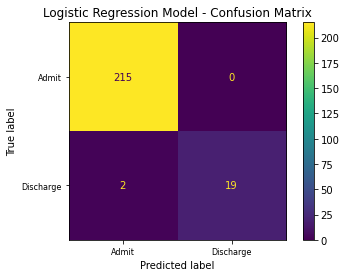

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.yticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


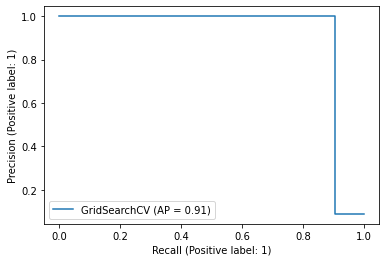

In [ ]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_precision_recall_curve(clf, X_test, y_test, pos_label=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


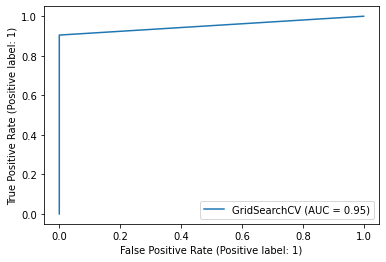

In [ ]:
plot_roc_curve(clf, X_test, y_test, pos_label=1)
